# Melanoma Detection Assignment

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
# import necessary libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.datasets import load_files
from keras.utils import np_utils
from collections import Counter

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("dataset/train")
data_dir_test = pathlib.Path('dataset/test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


We have a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# Create Dataset

Define batch size, standard image height and width parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

### Create the training and test data

In [5]:
train_ds = image_dataset_from_directory(
    seed=123,
    directory=data_dir_train,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width))

val_ds = image_dataset_from_directory(
    seed=123,
    directory=data_dir_test,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width))

Found 2239 files belonging to 9 classes.
Metal device set to: Apple M1 Pro
Found 118 files belonging to 9 classes.


2022-07-26 15:47:14.485853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-26 15:47:14.486136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### we have a total of 9 classes that we need to classify into.

# Visualize the dataset

In [7]:
# let's see the samples for all 9 classes. This will tell if we have balanced data or imbalanced data.

def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 9)
    
    return files, targets

In [8]:
train_filenames, train_targets = load_data_raw(data_dir_train)

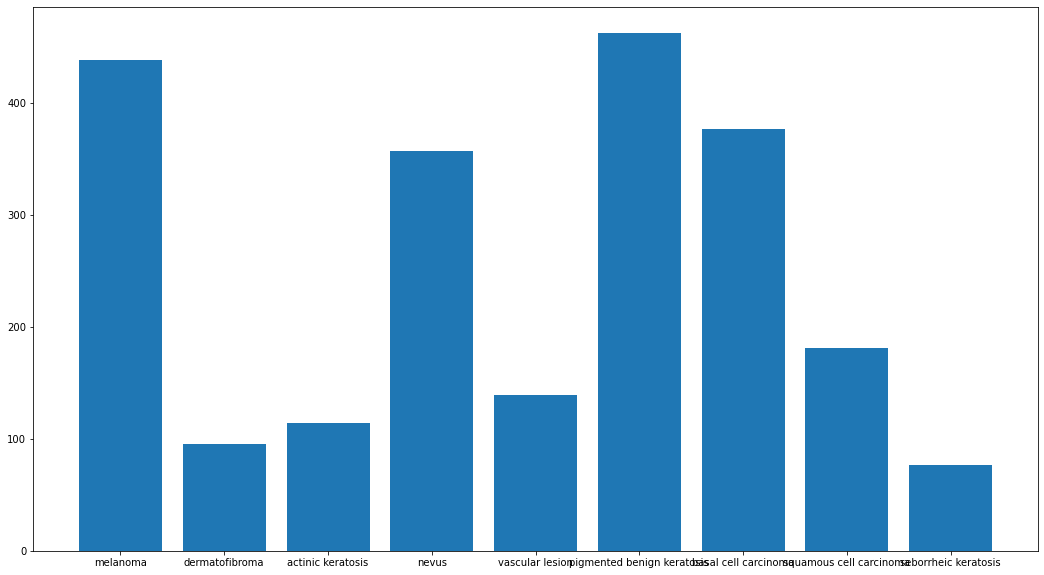

In [9]:
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.figure(figsize=(18, 10))
plt.bar(classes_count.keys(), classes_count.values())
plt.show()

# we don't have an even distribution of training dataset
- Which class has the least number of samples?
  seborrheic keratosis has the least amount of samples ~90
- Which classes dominate the data in terms proportionate number of samples?
  pigmented benigh keratosis has the largest amount of samples ~450

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
input_shape = (img_height, img_width, 3)

# Create the model

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# model
model = Sequential()


# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(9, activation='softmax'))

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 88, 64)        0         
                                                                 
 flatten (Flatten)           (None, 495616)            0         
                                                                 
 dense (Dense)               (None, 128)               63438976  
                                                        

#### The above diagram explains the neural network model we have build. The model has three reLU units and the final layer which is a dense layer that has softmax activation for predicting multi-class probability output. We use a dropout of 0.5 in between for regularization. We have also used the categorical cross-entropy as our loss function with the Adam optimizer.

# Fitting and Evaluating the Model

In [13]:
# usual cross entropy loss
# choose any optimiser such as adam, rmsprop etc
# metric is accuracy
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Train the Model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-07-26 15:47:40.812791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-26 15:47:40.816738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 17.8680 - accuracy: 0.1510

2022-07-26 15:48:09.826331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 32s 385ms/step - loss: 17.8680 - accuracy: 0.1510 - val_loss: 2.3286 - val_accuracy: 0.1186
Epoch 2/20
70/70 [==============================] - 25s 358ms/step - loss: 2.2873 - accuracy: 0.1840 - val_loss: 2.3265 - val_accuracy: 0.1186
Epoch 3/20
70/70 [==============================] - 25s 358ms/step - loss: 2.2162 - accuracy: 0.1867 - val_loss: 2.3309 - val_accuracy: 0.1186
Epoch 4/20
70/70 [==============================] - 25s 351ms/step - loss: 2.2068 - accuracy: 0.1934 - val_loss: 2.3100 - val_accuracy: 0.1186
Epoch 5/20
70/70 [==============================] - 25s 358ms/step - loss: 2.2055 - accuracy: 0.1965 - val_loss: 2.3101 - val_accuracy: 0.1186
Epoch 6/20
70/70 [==============================] - 25s 356ms/step - loss: 2.1868 - accuracy: 0.1992 - val_loss: 2.3105 - val_accuracy: 0.1186
Epoch 7/20
70/70 [==============================] - 25s 355ms/step - loss: 2.2085 - accuracy: 0.1987 - val_loss: 2.3098 - val_accuracy: 0.1356
Epoch 8/2

## Visualizing training results

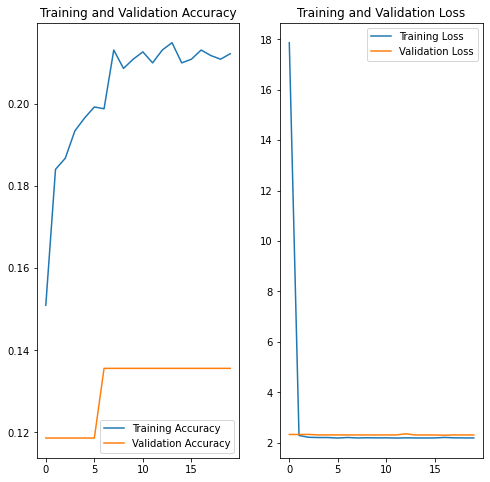

In [15]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The model accuracy is very low ~/.2. This is owing to the fact that the dataset is highly imbalanced.

# Let's create another model with different parameters

In [16]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

In [19]:
nb_epochs = 10
nb_fc_neurons = 512
nb_filter = 32
nb_conv2d = 3

model = Sequential()
    
model.add(Conv2D(nb_filter, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(nb_filter*2, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(nb_filter*4, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Flatten())
model.add(Dense(nb_fc_neurons))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('sigmoid'))
    
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])



In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 87, 87, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-07-26 17:40:20.116765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 24.9471 - accuracy: 0.2483

2022-07-26 17:40:29.620247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 11s 129ms/step - loss: 24.9471 - accuracy: 0.2483 - val_loss: 2.5545 - val_accuracy: 0.1864
Epoch 2/20
70/70 [==============================] - 6s 84ms/step - loss: 2.0180 - accuracy: 0.3149 - val_loss: 2.3505 - val_accuracy: 0.1441
Epoch 3/20
70/70 [==============================] - 6s 84ms/step - loss: 1.9010 - accuracy: 0.2966 - val_loss: 2.4571 - val_accuracy: 0.2373
Epoch 4/20
70/70 [==============================] - 6s 84ms/step - loss: 1.8333 - accuracy: 0.3314 - val_loss: 2.2653 - val_accuracy: 0.2119
Epoch 5/20
70/70 [==============================] - 6s 82ms/step - loss: 1.8916 - accuracy: 0.3350 - val_loss: 2.3030 - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 6s 81ms/step - loss: 2.1425 - accuracy: 0.2126 - val_loss: 2.2178 - val_accuracy: 0.1525
Epoch 7/20
70/70 [==============================] - 6s 86ms/step - loss: 2.0026 - accuracy: 0.2269 - val_loss: 2.2258 - val_accuracy: 0.1441
Epoch 8/20
70/70 [===

#### This model has a bit better accuracy than previous one but still the accuracy is very poor. We need to augment data and balance the dataset

# Balancing Dataset

In [22]:
# Using Augmentor

!pip install Augmentor

In [27]:
import Augmentor
for i in class_names:
    path = "dataset/train/" + str(i)
    p = Augmentor.Pipeline(path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to dataset/train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E1D11670>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 221.17 Samples/s]


Initialised with 376 image(s) found.
Output directory set to dataset/train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x146C2F880>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 242.89 Samples/s]


Initialised with 95 image(s) found.
Output directory set to dataset/train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x145C6B670>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 239.51 Samples/s]


Initialised with 438 image(s) found.
Output directory set to dataset/train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2E1D23D60>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to dataset/train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1400E4B20>: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.47 Samples/s]


Initialised with 462 image(s) found.
Output directory set to dataset/train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x145C647F0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 186.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to dataset/train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x290B96100>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 92.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to dataset/train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2E2356910>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 175.27 Samples/s]


Initialised with 139 image(s) found.
Output directory set to dataset/train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x145C6AAC0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 193.92 Samples/s]


In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [32]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['dataset/train/melanoma/output/melanoma_original_ISIC_0009905.jpg_69c96d0b-dd96-4574-a6dd-f4e4b6eca378.jpg',
 'dataset/train/melanoma/output/melanoma_original_ISIC_0010934.jpg_821e3c58-b6d2-4ad6-af81-69837e21cfec.jpg',
 'dataset/train/melanoma/output/melanoma_original_ISIC_0010162.jpg_575c704e-050d-4352-9f1b-9f5a2e35eb47.jpg',
 'dataset/train/melanoma/output/melanoma_original_ISIC_0000432.jpg_dae1ce57-6fe3-49e9-836b-1b46c9964222.jpg',
 'dataset/train/melanoma/output/melanoma_original_ISIC_0010486.jpg_7b30d87d-af3e-4163-9aaa-4dec5509b620.jpg',
 'dataset/train/melanoma/output/melanoma_original_ISIC_0001119.jpg_7e36f741-2cf8-4811-9aba-372ccbf1a4f2.jpg',
 'dataset/train/melanoma/output/melanoma_original_ISIC_0010866.jpg_bf2a769f-b01f-4da9-b0a1-c9ba2a859732.jpg',
 'dataset/train/melanoma/output/melanoma_original_ISIC_0009934.jpg_75cb2bed-3e1c-457e-8af0-ca6423539414.jpg',
 'dataset/train/melanoma/output/melanoma_original_ISIC_0000292.jpg_e4caac2a-d412-4ca0-8350-c39ae1494c75.jpg',
 'dataset/

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [36]:
df2['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

<AxesSubplot:>

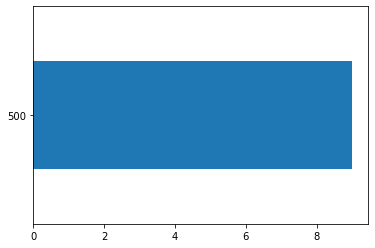

In [37]:
df2['Label'].value_counts().value_counts().plot(kind = 'barh')

In [38]:
# define batch-size and image-height, width for the new dataset.
batch_size = 32
img_height = 180
img_width = 180

In [39]:
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [40]:
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [41]:
# model
model = Sequential()


# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(9, activation='softmax'))

# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 88, 88, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 88, 88, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 495616)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               63438976  
                                                      

In [42]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [43]:
epochs = 50
history = model.fit(
  train_ds_new,
  validation_data=val_ds_new,
  epochs=epochs
)

Epoch 1/50


2022-07-26 17:58:55.821978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - ETA: 0s - loss: 209.9325 - accuracy: 0.1875

2022-07-26 17:59:56.487313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - 72s 406ms/step - loss: 209.9325 - accuracy: 0.1875 - val_loss: 2.0089 - val_accuracy: 0.2799
Epoch 2/50
169/169 [==============================] - 67s 394ms/step - loss: 2.1863 - accuracy: 0.2732 - val_loss: 1.9829 - val_accuracy: 0.2814
Epoch 3/50
169/169 [==============================] - 67s 394ms/step - loss: 1.8376 - accuracy: 0.3576 - val_loss: 1.8462 - val_accuracy: 0.3615
Epoch 4/50
169/169 [==============================] - 67s 395ms/step - loss: 1.5686 - accuracy: 0.4664 - val_loss: 1.7849 - val_accuracy: 0.4001
Epoch 5/50
169/169 [==============================] - 67s 395ms/step - loss: 1.7507 - accuracy: 0.4000 - val_loss: 2.0601 - val_accuracy: 0.3192
Epoch 6/50
169/169 [==============================] - 68s 400ms/step - loss: 1.5071 - accuracy: 0.4946 - val_loss: 1.9266 - val_accuracy: 0.3979
Epoch 7/50
169/169 [==============================] - 68s 399ms/step - loss: 1.3791 - accuracy: 0.5569 - val_loss: 1.8525 - val_accuracy: 0

### After Augmenting we can see accuracy has increased from .2 to .9.

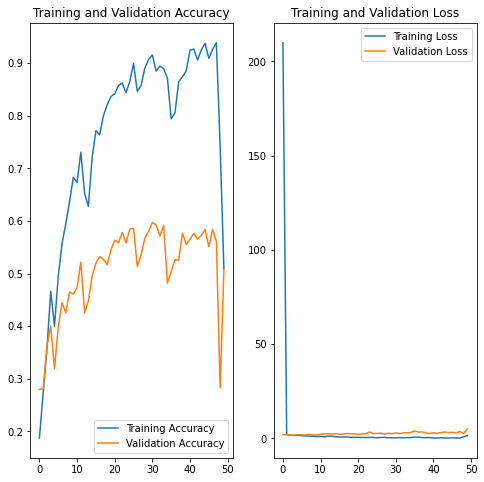

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Final Inference:

Accuracy increased considerably after class rebalancing. We built a neural network model that has three reLU units and the final layer which is a dense layer that has softmax activation for predicting multi-class probability output. We use a dropout of 0.5 in between for regularization. We have also used the categorical cross-entropy as our loss function with the Adam optimizer.